# 2.4.2. Оценка близости двух текстов.  

Видеоуроки:  
2.4.1. Векторное представление единиц текста.  
**2.4.2. Оценка близости двух текстов.**  
2.4.3. Модель word2vec сервиса RusVectōrēs.  

Дополнительные материалы:  
2.4.4. Скринкаст "Оценка семантической близости вопросов и ответов с использованием модели FastText сервиса RusVectōrēs".  
2.4.5. Скринкаст "Оценка семантической близости вопросов и ответов с использованием модели Elmo сервиса RusVectōrēs".  


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
import numpy as np

plt.style.use('ggplot')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

В предыдущей теме мы разобрали векторизацию текста - преобразование текста в числовой вектор.  
В этом уроке мы разберем задачу определения степени сходства 2 текстов.  
Нам понадобится корпус текстов для анализа.  
В папке `'./data/volgatech_faq'` представлен датасет:  
Описание файлов данных:  
* `questions.csv` - вопросы пользователей;  
* `answers.csv` - ответы на вопросы;  
* `pos_relations.csv` - правильные ответы на вопросы (пары вопрос==ответ);  
* `neg_relations.csv` - неправильные (неподходящие) ответы.  
  
Для наших целей достаточно будет только вопросов.  


In [1]:
!ls ./data/volgatech_faq

answers.csv       neg_relations.csv questions.csv
data.zip          pos_relations.csv


In [6]:
df_questions = pd.read_csv('./data/volgatech_faq/questions.csv', sep=';', names=['id', 'text'])
df_questions.head()

,id,text
0,3647,размерность векторного пространства
1,3644,расстояние
2,3643,привет
3,3631,что такое подпространство
4,3630,матрица перехода к новому базису


In [8]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      187 non-null    int64 
 1   text    187 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


## Count vectorizer  

Задача - кодировать текст документа в вектор.  
Число слов в корпусе равно $K$  
Сопоставим документу с номером $j$ вектор длины $K$. Значение $K_{i}$ соответствует количеству (абсолютной частоте) встречаемости слова $i$ в тексте $j$.  
Смысл документа представлен частотой слов этого документа.  
  
Недостатки:
 - OOV слова игнорируются.  
 - Размер вектора $K$ растет с ростом словаря.  

In [69]:
corpora = df_questions['text']

# Параметры по умолчанию разбивают текст на токены длиной не менее 2 символов.
# в примере ниже `и` будет проигнорирован.
count_vectorizer = CountVectorizer()
count_vectorizer.fit(corpora)

print('Размер словаря:', len(count_vectorizer.get_feature_names_out()))

t = corpora[0]
print('Текст:', t)
print('Вектор:', count_vectorizer.transform([t]).toarray())


Размер словаря: 136
Текст: размерность векторного пространства
Вектор: [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


Для удобного отображения "точек" текстов на графике, мы можем снизить размерность выходного вектора методом главных компонент. Снизим размерность до 2 и отобразим на графике несколько текстов:

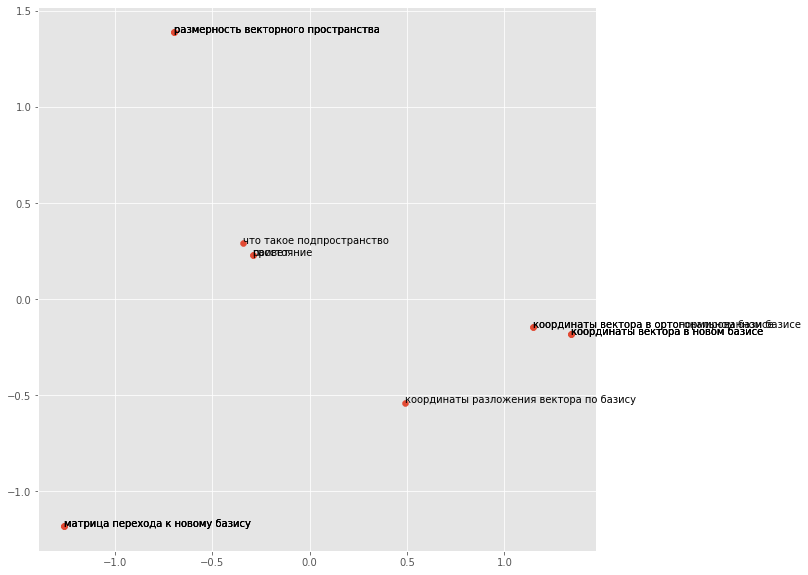

In [28]:
texts = corpora[:15]
text_vects = [count_vectorizer.transform([t]).toarray()[0] for t in texts]
tv_r = PCA(n_components=2).fit(text_vects).transform(text_vects)
xs = [xy[0] for xy in tv_r]
ys = [xy[1] for xy in tv_r]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(xs, ys)
for i, t in enumerate(texts):
    ax.annotate(t, (xs[i], ys[i]))


На графике видно, что тексты с похожими словами (частотами слов) находятся близко друг к другу. Мы можем говорить, что сочетания слов в тексте отражают смысл текста. И более того, смысл текста меняется в зависимости от "соседей" (слов, совместно с которыми оно употребляется). Так в тексте "деревянный гриф" скорее всего имеется в виду гриф гитары, а "низко летит гриф" - птица.  

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Classical_Guitar_labelled_russian.jpg" alt="guitar" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Gyps_bengalensis_by_Ravi_Sangeetha_%28cropped%29.jpg/1024px-Gyps_bengalensis_by_Ravi_Sangeetha_%28cropped%29.jpg" alt="gyps" width="100"/>


Для того, чтобы определить меру близости, мы можем вычислить расстояние между 2 векторами текстов.  
В качестве меры расстояния возьмем [Евклидово расстояние](https://ru.wikipedia.org/wiki/Евклидова_метрика).  
Для того, чтобы найти текст, наиболее похожий на заданный, мы можем вычислить вектора всех текстов в "базе" и вектор анализируемого текста, далее вычислим расстояние от заданного вектора до каждого вектора в базе.  

In [68]:
text_vects = [count_vectorizer.transform([t]).toarray() for t in corpora]
# зададим несколько текстов для анализа
texts = corpora[:5]
n_neighbors = 5

for t in texts:
    v = count_vectorizer.transform([t]).toarray()
    distances = [euclidean_distances(v, tv)[0][0] for tv in text_vects]
    d_sorted = np.argsort(distances) # возвращается индексы значений отсортированного массива

    print('Анализируемый текст:', t)
    print('сосед'.ljust(35), 'расстояние', sep='\t')
    for i in range(n_neighbors):
        print(corpora[i].ljust(35),  distances[i], sep='\t')
    print('-'*60)




Анализируемый текст: размерность векторного пространства
сосед                              	расстояние
размерность векторного пространства	0.0
расстояние                         	2.0
привет                             	2.0
что такое подпространство          	2.449489742783178
матрица перехода к новому базису   	2.6457513110645907
------------------------------------------------------------
Анализируемый текст: расстояние
сосед                              	расстояние
размерность векторного пространства	2.0
расстояние                         	0.0
привет                             	1.4142135623730951
что такое подпространство          	2.0
матрица перехода к новому базису   	2.23606797749979
------------------------------------------------------------
Анализируемый текст: привет
сосед                              	расстояние
размерность векторного пространства	2.0
расстояние                         	1.4142135623730951
привет                             	0.0
что такое подпространство   

# Выводы:  
* Представление текста в виде вектора может быть удобным для различных задач машинного обучения, в том числе для анализа степени схожеси 2 текстов.  